In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [x['color'] for x in plt.style.library['seaborn']['axes.prop_cycle']]
from matplotlib import cm

# Income process estimation

**Function for simulation:**

In [2]:
def simulate(T,N,sigma_psi,sigma_xi,pi,seed):
    """ simulate income process
    
    Args:
        
        T (int): number of periods
        N (int): number of persons
        sigma_psi (float): std. of permanent shocks
        sigma_xi (float): std. of transitory shocks
        pi (float): unemployment risk  
        seed (int): seed for random numbers
        
    Returns:
    
        Y (np.ndarray): income
        
    """
    
    # a. allocate
    Y = np.nan*np.ones((T,N))
    P = np.nan*np.ones((T,N))
    
    # b. draw random shocks
    np.random.seed(seed)
    psi = np.random.lognormal(-0.5*sigma_psi**2,sigma_psi,size=(T,N))
    xi = np.random.lognormal(-0.5*sigma_xi**2,sigma_xi,size=(T,N))
    mu = np.random.uniform(size=(T,N))
    
    # b. simulate
    for t in range(T):
        
        # i. previous period
        if t == 0:
            Plag = 1
        else:
            Plag = P[t-1,:]
        
        # ii. permanent and transitory shocks
        P[t,:] = Plag*psi[t,:]
        Y[t,:] = P[t,:]*xi[t,:]
        
        # iii. unemployment
        I = mu[t,:] < pi
        Y[t,I] = 0
    
    return Y

**Create data:**

In [3]:
# a. settings
data_T = 20
data_N = 50_000
data_seed = 1917
true_sigma_psi = 0.10
true_sigma_xi = 0.15
true_pi = 0.05

# b. simulate
dataY = simulate(data_T,data_N,true_sigma_psi,true_sigma_xi,true_pi,data_seed)

# c. save
with open('dataY.npy', 'wb') as f:
    np.save(f,dataY)

## Question 1

In [4]:
dataY = np.load('dataY.npy')

In [5]:
def growth_rate(Y):    
    """ simulate income process
    
    Args:
        
        Y (np.ndarray): income      
        
    Returns:
    
        dlogY (np.ndarray): log-change in income
        
    """

    T,N = Y.shape
    dlogY = np.nan*np.ones((T,N))
    for t in range(T):
        I = (Y[t,:] > 0) & (Y[t-1,:] > 0)
        dlogY[t,I] = np.log(Y[t,I])-np.log(Y[t-1,I])
        
    return dlogY

dlogdataY = growth_rate(dataY)

## Question 2

In [6]:
def calculate_statistics(Y,dlogY):
    """ calculate statistics
    
    Args:
        
        Y (np.ndarray): income      
        dlogY (np.ndarray): log-change in income
        
    Returns:
        
        s1 (float): share of observations with zero
        s2 (float): variance of income growth
        s3 (float): co-variance of income growth
        
    """
    
    # a. s1
    mean_Yzero = np.mean(Y == 0)
    
    # b. s2
    I = ~np.isnan(dlogY)
    var_dlogY = np.var(dlogY[I])
    
    # c. s3
    dlogY_now = dlogY[1:,:]
    dlogY_lag = dlogY[:-1,:]
    I = (~np.isnan(dlogY_now)) & (~np.isnan(dlogY_lag))
    cov_dlogY = np.cov(dlogY_now[I],dlogY_lag[I])[0,1]
    
    return mean_Yzero,var_dlogY,cov_dlogY

data_mean_Yzero,data_var_dlogY,data_cov_dlogY = calculate_statistics(dataY,dlogdataY)

## Question 3

In [7]:
# a. choices
T = 20
N = 100_000
seed = 1986
sigma_psi = 0.05
sigma_xi = 0.10
pi = 0.04

# a. simulate
simY = simulate(T,N,sigma_psi,sigma_xi,pi,seed)

# b. calculate statistics
dlogsimY = growth_rate(simY)
mean_Yzero,var_dlogY,cov_dlogY = calculate_statistics(simY,dlogsimY)

# c. compare with data statistics
print(f'mean_Yzero: {mean_Yzero:7.4f} (sim) vs. {data_mean_Yzero:7.4f} (data)')
print(f' var_dlogY: {var_dlogY:7.4f} (sim) vs. {data_var_dlogY:7.4f} (data)')
print(f' cov_dlogY: {cov_dlogY:7.4f} (sim) vs. {data_cov_dlogY:7.4f} (data)')

mean_Yzero:  0.0400 (sim) vs.  0.0499 (data)
 var_dlogY:  0.0248 (sim) vs.  0.0645 (data)
 cov_dlogY: -0.0101 (sim) vs. -0.0230 (data)


## Question 4

In [8]:
def objective(x,data_mean_Yzero,data_var_dlogY,data_cov_dlogY,T,N,seed):
    
    # a. unpack
    sigma_psi = x[0]
    sigma_xi = x[1]
    pi = x[2]
    
    # b. simulate
    simY = simulate(T,N,sigma_psi,sigma_xi,pi,seed)
    
    # c. calculate moments
    dlogsimY = growth_rate(simY)
    mean_Yzero,var_dlogY,cov_dlogY = calculate_statistics(simY,dlogsimY)
    
    # d. calculate objective
    obj = (mean_Yzero-data_mean_Yzero)**2 + (var_dlogY-data_var_dlogY)**2 + (cov_dlogY-data_cov_dlogY)**2
    return obj 

In [9]:
x = [sigma_psi,sigma_xi,pi]
res = optimize.minimize(objective,x,method='L-BFGS-B',bounds=((0,None),(0,None),(0,1)),args=(data_mean_Yzero,data_var_dlogY,data_cov_dlogY,T,N,seed),
                        options={'eps':1e-4})
assert res.success

In [10]:
print(f'sigma_psi: {res.x[0]:.4f} [true: {true_sigma_psi:.4f}]')
print(f' sigma_xi: {res.x[1]:.4f} [true: {true_sigma_xi:.4f}]')
print(f'       pi: {res.x[2]:.4f} [true: {true_pi:.4f}]')

sigma_psi: 0.1001 [true: 0.1000]
 sigma_xi: 0.1499 [true: 0.1500]
       pi: 0.0498 [true: 0.0500]


**See optimizer results:**

In [11]:
res

      fun: 4.533508167430575e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.46516131e-08, -9.21598742e-09, -1.41513704e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([0.10013867, 0.14989204, 0.04976324])

**Compare statistics:**

In [12]:
# a. unpack results
sigma_psi = res.x[0]
sigma_xi = res.x[1]
pi = res.x[2]

# b. simulate and calculate statistics
simY = simulate(T,N,sigma_psi,sigma_xi,pi,seed)
dlogsimY = growth_rate(simY)
mean_Yzero,var_dlogY,cov_dlogY = calculate_statistics(simY,dlogsimY)

# c. compare withd ata
print(f'mean_Yzero: {mean_Yzero:7.4f} (sim) vs. {data_mean_Yzero:7.4f} (data)')
print(f' var_dlogY: {var_dlogY:7.4f} (sim) vs. {data_var_dlogY:7.4f} (data)')
print(f' cov_dlogY: {cov_dlogY:7.4f} (sim) vs. {data_cov_dlogY:7.4f} (data)')

mean_Yzero:  0.0499 (sim) vs.  0.0499 (data)
 var_dlogY:  0.0644 (sim) vs.  0.0645 (data)
 cov_dlogY: -0.0230 (sim) vs. -0.0230 (data)


# Wealth in the utility function

In [13]:
# a. parameters
rho = 2.0
sigma = 1.2
kappa = 0.6
a_ubar = 2.0
r = 0.04
y = 1.0

# b. grids
a_lag_vec = np.linspace(0,300,300)

In [14]:
beta = 0.97
T = 20

## Question 1

In [15]:
def solve(a_lag_vec,beta,rho,sigma,kappa,a_ubar,r,y,interp_next_v=None):

    # a. grids
    v_vec = np.empty(a_lag_vec.size)
    c_vec = np.empty(a_lag_vec.size)

    # b. solve for each a_lag in grid
    for i,a_lag in enumerate(a_lag_vec):

        # i. objective
        m = (1+r)*a_lag + y
        def obj(c):
            a = m - c
            c_utility = c**(1-rho)/(1-rho)
            a_utility = kappa*(a+a_ubar)**(1-sigma)/(1-sigma)
            utility = c_utility + a_utility
            if not interp_next_v is None:
                utility += beta*interp_next_v(a)
            return -utility           

        # ii. optimizer
        result = optimize.minimize(obj,[0.01*m],method='L-BFGS-B',bounds=((1e-8,m),))
        
        # iv. save
        v_vec[i] = -result.fun
        c_vec[i] = result.x
        
    return v_vec,c_vec

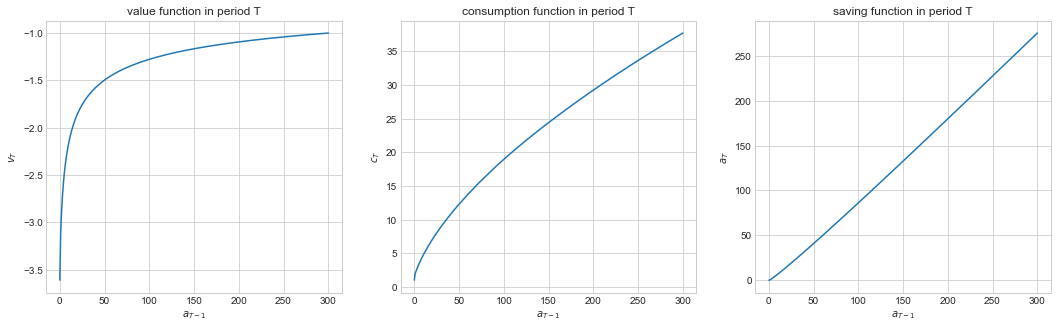

In [16]:
# solve
vT_vec,cT_vec = solve(a_lag_vec,beta,rho,sigma,kappa,a_ubar,r,y)

# illustration
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(1,3,1)
ax.plot(a_lag_vec,vT_vec)
ax.set_xlabel('$a_{T-1}$')
ax.set_ylabel('$v_T$')
ax.set_title('value function in period T');

ax = fig.add_subplot(1,3,2)
ax.plot(a_lag_vec,cT_vec)
ax.set_xlabel('$a_{T-1}$')
ax.set_ylabel('$c_T$')
ax.set_title('consumption function in period T')

aT_vec = (1+r)*a_lag_vec+y-cT_vec
ax = fig.add_subplot(1,3,3)
ax.plot(a_lag_vec,aT_vec)
ax.set_xlabel('$a_{T-1}$')
ax.set_ylabel('$a_T$')
ax.set_title('saving function in period T');

## Questions 2+3

In [17]:
def solve_full(a_lag_vec,vT_vec,beta,rho,sigma,kappa,a_ubar,r,y,T):
    
    T = 20
    v_next_vec = vT_vec
    c_vecs = np.zeros((T,a_lag_vec.size))
    for t in reversed(range(T)):
        
        print(f't = {t}')
        v_next_interp = interpolate.RegularGridInterpolator((a_lag_vec,),v_next_vec,bounds_error=False,fill_value=None)   
        v_next_vec,c_vecs[t,:] = solve(a_lag_vec,beta,rho,sigma,kappa,a_ubar,r,y,v_next_interp)
    
    return c_vecs

c_vecs = solve_full(a_lag_vec,vT_vec,beta,rho,sigma,kappa,a_ubar,r,y,T)

t = 19
t = 18
t = 17
t = 16
t = 15
t = 14
t = 13
t = 12
t = 11
t = 10
t = 9
t = 8
t = 7
t = 6
t = 5
t = 4
t = 3
t = 2
t = 1
t = 0


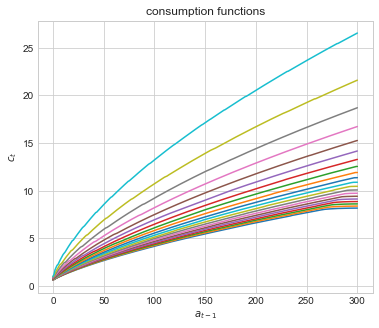

In [18]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)
for t in range(T):
    ax.plot(a_lag_vec,c_vecs[t])
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t$')
ax.set_title('consumption functions');

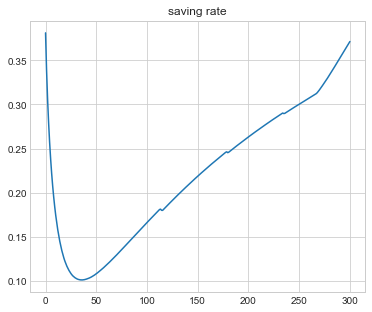

In [19]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)
s_vec = (1+r)*a_lag_vec+y-c_vecs[0,:]-a_lag_vec
s_rate_vec = s_vec/(r*a_lag_vec+y)
ax.plot(a_lag_vec,s_rate_vec)
ax.set_title('saving rate');

## Question 4

In [20]:
kappa_zero = 0.0
vT_vec,cT_vec = solve(a_lag_vec,beta,rho,sigma,kappa_zero,a_ubar,r,y)
c_vecs_kappa_zero = solve_full(a_lag_vec,vT_vec,beta,rho,sigma,kappa_zero,a_ubar,r,y,T)

t = 19
t = 18
t = 17
t = 16
t = 15
t = 14
t = 13
t = 12
t = 11
t = 10
t = 9
t = 8
t = 7
t = 6
t = 5
t = 4
t = 3
t = 2
t = 1
t = 0


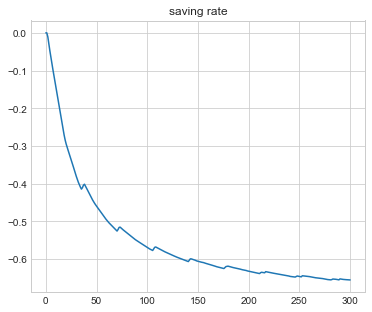

In [21]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)
s_vec = (1+r)*a_lag_vec+y-c_vecs_kappa_zero[0,:]-a_lag_vec
s_rate_vec = s_vec/(r*a_lag_vec+y)
ax.plot(a_lag_vec,s_rate_vec)
ax.set_title('saving rate');

# Gradient descent

## Question 1

In [22]:
def grid_search(f,x1_min,x1_max,x2_min,x2_max,N):
    
    f_best = np.inf
    for x1 in np.linspace(x1_min,x1_max,N):
        for x2 in np.linspace(x2_min,x2_max,N):
            f_now = f([x1,x2])
            if f_now < f_best:
                f_best = f_now
                x1_best = x1
                x2_best = x2
            
    return x1_best,x2_best,f_best

In [23]:
def refined_grid_search(f,x1_min,x1_max,x2_min,x2_max,N,K):
    
    for k in range(K):
        if k > 0:
            
            step_x1 = 3*(x1_max-x1_min)/(N-1)
            step_x2 = 3*(x2_max-x2_min)/(N-1)
            
            x1_min = np.fmax(x1_best-step_x1,x1_min)
            x2_min = np.fmax(x2_best-step_x2,x2_min)
            x1_max = np.fmin(x1_best+step_x1,x1_max)
            x2_max = np.fmin(x2_best+step_x2,x2_max)
            
        x1_best,x2_best,f_best = grid_search(f,x1_min,x1_max,x2_min,x2_max,N)
        
        print(f'{k:2d}: x = ({x1_best:.8f},{x2_best:.8f}) -> {f_best:.8f}')
        
    return x1_best,x2_best,f_best

In [24]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x1_min = 0
x1_max = 5
x2_min = 0
x2_max = 4
N = 100

x1,x2,f = grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N)
print(x1,x2,f)

1.0101010101010102 1.0101010101010102 0.0003102344761977566


In [25]:
K = 10
x1,x2,f = refined_grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N,K)

 0: x = (1.01010101,1.01010101) -> 0.00031023
 1: x = (0.99938782,0.99908173) -> 0.00000056
 2: x = (1.00003710,1.00004638) -> 0.00000000
 3: x = (0.99999775,0.99999691) -> 0.00000000
 4: x = (1.00000014,1.00000045) -> 0.00000000
 5: x = (0.99999999,0.99999997) -> 0.00000000
 6: x = (1.00000000,1.00000000) -> 0.00000000
 7: x = (1.00000000,1.00000000) -> 0.00000000
 8: x = (1.00000000,1.00000000) -> 0.00000000
 9: x = (1.00000000,1.00000000) -> 0.00000000
